Imports & Initial Experiments

In [1]:
# !ls data

# !pip install pandas

# !pip install chardet

# !pip install transformers

# !pip install seaborn

# !pip install statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import re
import transformers
import pandas as pd
import chardet
import numpy as np
import os
from transformers import BertModel, BertTokenizer
import torch
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\batik\miniconda3\envs\0General\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = 'wind_turbine_data/2019-08-14.csv'
# file_path = 'wind_turbine_data/2021-02-25.csv'
sample = pd.read_csv(file_path, sep="\t", on_bad_lines='skip')
sample

,Kreis,Gemeinde,Anlage,Leistung,Nabenhöhe,Rotordurchmesser,AN_RW,AN_HW,Status
0,Kiel,Kiel,0001 - WKA 1 Nordex N131,3000 kW Nennleist. Rotor.,134,131,32571605.0,6013660.0,im Gen.Verf.
1,Kiel,Kiel,0002 - WKA 2 Nordex N131,3000 kW Nennleist. Rotor.,134,131,32572117.0,6013490.0,im Gen.Verf.
2,Kiel,Kiel,0003 - WKA 3 Nordex N131,3000 kW Nennleist. Rotor.,134,131,32572497.0,6013607.0,im Gen.Verf.
3,Lübeck,Lübeck,0001 - WKA - Ivendorf,2300 kW Nennleist. Rotor.,85,82,32619817.0,5978875.0,in Betrieb
4,Lübeck,Lübeck,0002 - WKA - Pöppendorf,2300 kW Nennleist. Rotor.,85,82,32619815.0,5977994.0,in Betrieb
...,...,...,...,...,...,...,...,...,...
3823,Stormarn,Feldhorst,0002 - WKA Typ Jacobs MD 70,1500 kW Nennleist. Rotor.,65,70,32593273.0,5969688.0,in Betrieb
3824,Stormarn,Feldhorst,0005 - WKA Typ Jacobs MD 70,1500 kW Nennleist. Rotor.,65,70,32594262.0,5969348.0,in Betrieb
3825,Stormarn,Feldhorst,0004 - WKA Typ Jacobs MD 70,1500 kW Nennleist. Rotor.,65,70,32594038.0,5969465.0,in Betrieb
3826,Stormarn,Feldhorst,0006 - WKA Typ Jacobs MD 70,1500 kW Nennleist. Rotor.,65,70,32594330.0,5969631.0,in Betrieb


## Join Data

In [3]:
def detect_separator(filename, encoding='utf-8'):
    delimiters = [',', ';', '\t', '|', ' ']  # Common delimiters
    max_columns = 0
    best_delimiter = ','

    for delimiter in delimiters:
        try:
            # Try reading the file with the given delimiter and encoding
            df = pd.read_csv(filename, delimiter=delimiter, nrows=10, encoding=encoding)
            if len(df.columns) > max_columns:
                max_columns = len(df.columns)
                best_delimiter = delimiter
        except Exception as e:
            print(f"Skipping delimiter {delimiter} due to error: {e}")

    return best_delimiter

In [4]:


directory = 'wind_turbine_data'
result_df = pd.DataFrame()
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        print(f"{file_path=}")
        
        
        # Detect the encoding of the file
        with open(file_path, 'rb') as file:
#             result = chardet.detect(file.read())  # read the whole file; might be inefficient for large files
              result = chardet.detect(file.read(10000))  # Read only the first 10000 bytes

        encoding = result['encoding']
        detected_sep = detect_separator(file_path, encoding)

        try:
            # Now read the CSV with detected encoding
            data = pd.read_csv(file_path, encoding=encoding, sep=detected_sep, on_bad_lines='skip')#, sep="\t", on_bad_lines='skip')

            print(f"Data from {filename}:")
            print(data.columns[0])
            data.columns = [col.replace('"', '') for col in data.columns]
#             print(data['LEISTUNGSBEZUG'])
            print("LEISTUNGSBEZUG" in data.columns)
            if "LEISTUNGSBEZUG" in data.columns:
                result_df = pd.concat([result_df, data], axis=0)
                
                
            print(data.head())
#             print(data)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
        print("\n")  # Adds a newline for better readability between files
    else:
        continue  # Skip non-CSV files


file_path='wind_turbine_data\\2019-08-14.csv'
Skipping delimiter   due to error: Error tokenizing data. C error: Expected 10 fields in line 8, saw 14

Data from 2019-08-14.csv:
Kreis
False
    Kreis Gemeinde                    Anlage                   Leistung  \
0    Kiel     Kiel  0001 - WKA 1 Nordex N131  3000 kW Nennleist. Rotor.   
1    Kiel     Kiel  0002 - WKA 2 Nordex N131  3000 kW Nennleist. Rotor.   
2    Kiel     Kiel  0003 - WKA 3 Nordex N131  3000 kW Nennleist. Rotor.   
3  Lübeck   Lübeck     0001 - WKA - Ivendorf  2300 kW Nennleist. Rotor.   
4  Lübeck   Lübeck   0002 - WKA - Pöppendorf  2300 kW Nennleist. Rotor.   

  Nabenhöhe Rotordurchmesser       AN_RW      AN_HW        Status  
0       134              131  32571605.0  6013660.0  im Gen.Verf.  
1       134              131  32572117.0  6013490.0  im Gen.Verf.  
2       134              131  32572497.0  6013607.0  im Gen.Verf.  
3        85               82  32619817.0  5978875.0    in Betrieb  
4        85         

In [5]:
result_df = result_df.reset_index(drop=True)

In [6]:
result_df.describe()

,OSTWERT,NORDWERT,BST_NR,ANL_NR
count,3.900000e+04,3.900000e+04,3.900800e+04,39008.000000
mean,2.280916e+07,6.018465e+06,5.536906e+10,7.710931
std,1.471622e+07,3.621007e+04,4.020792e+09,46.744826
min,4.718480e+05,5.919141e+06,2.000000e+09,1.000000
25%,5.704420e+05,5.985799e+06,5.301408e+10,1.000000
50%,3.250096e+07,6.013074e+06,5.416531e+10,3.000000
75%,3.252675e+07,6.051911e+06,5.907700e+10,6.000000
max,3.264678e+07,6.083820e+06,6.209345e+10,1006.000000


## Correct data types and fix simple string 

In [7]:
result_df.dtypes

KREIS                    object
GEMEINDE                 object
TYP                      object
HERSTELLER               object
NABENHOEHE               object
ROTORDURCHMESSER         object
SCHALLLEISTUNGSPEGEL     object
LEISTUNG                 object
LEISTUNGSBEZUG           object
OSTWERT                 float64
NORDWERT                float64
GENEHMIGT_AM             object
INBETRIEBNAHME           object
STATUS                   object
BST_NR                    int64
ANL_NR                    int64
DATENDATUM               object
DATENQUELLE              object
AKTENZEICHEN             object
dtype: object

### Correcting Columns, such as 'KREIS', 'GEMEINDE', 'TYP', 'HERSTELLER'

In [8]:
result_df['KREIS']

0            Kiel
1            Kiel
2            Kiel
3          Lübeck
4          Lübeck
           ...   
39003    Stormarn
39004    Stormarn
39005    Stormarn
39006    Stormarn
39007    Stormarn
Name: KREIS, Length: 39008, dtype: object

In [9]:
result_df['KREIS'].value_counts()

KREIS
Nordfriesland            9702
Dithmarschen             9495
Schleswig-Flensburg      5495
Ostholstein              4137
Steinburg                3532
Rendsburg-Eckernförde    3309
Segeberg                 1270
Hzgt.Lauenburg            821
Plön                      522
Stormarn                  471
Pinneberg                 194
Kiel                       30
Lübeck                     30
Name: count, dtype: int64

In [10]:
result_df['KREIS'] = result_df['KREIS'].astype('category')
result_df['KREIS']

0            Kiel
1            Kiel
2            Kiel
3          Lübeck
4          Lübeck
           ...   
39003    Stormarn
39004    Stormarn
39005    Stormarn
39006    Stormarn
39007    Stormarn
Name: KREIS, Length: 39008, dtype: category
Categories (13, object): ['Dithmarschen', 'Hzgt.Lauenburg', 'Kiel', 'Lübeck', ..., 'Schleswig-Flensburg', 'Segeberg', 'Steinburg', 'Stormarn']

In [11]:
# result_df['GEMEINDE'].value_counts()
result_df['GEMEINDE'] = result_df['GEMEINDE'].astype('category')


In [12]:
result_df['TYP'].value_counts()

TYP
WKA Enercon E-70 E4                                              1344
Enercon E-70/E4                                                  1052
Vestas V112                                                      1036
Enercon E-82                                                      577
Enercon E-101                                                     552
                                                                 ... 
WKA 8 Vestas V162-5.6MW                                             1
WKA P01 Vestas V162-5,6MW                                           1
WKA P02 Vestas V162 5.6MW                                           1
WKA P03 Vestas V162-5,6MW                                           1
NeuG: G10/2023/004 (genehmigt am 22.11.2023), Nordex N133 STE       1
Name: count, Length: 1520, dtype: int64

In [13]:
unique_types = result_df['TYP'].unique()
print(len(unique_types)) # 1521, so too long to manually check each item
# create embedding of each unique value and check cosine distances inbetween. If distance low, these may be the same value, so manually check and correct

1521


In [14]:


# load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

# preprocess the text
unique_types = result_df['TYP'].unique()
preprocessed_types = [str(type).lower().replace('/', ' ').replace('-', ' ') for type in unique_types]

# tokenize nd create embeddings
embeddings = []
for type in preprocessed_types:
    encoded_input = tokenizer(type, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    embeddings.append(output.pooler_output[0].numpy())

# calc cosine similarities
similarity_matrix = cosine_similarity(embeddings)

# dtermine threshold for considering categories as similar
threshold = 0.9  # for example, 90% similarity

# this gives you a matrix where each element [i, j] represents the similarity between type i and type j.


In [15]:
similarity_matrix

array([[1.0000001 , 0.9458934 , 0.9458934 , ..., 0.94212997, 0.97299516,
        0.9735173 ],
       [0.9458934 , 1.0000002 , 1.0000002 , ..., 0.9546178 , 0.93717647,
        0.9373857 ],
       [0.9458934 , 1.0000002 , 1.0000002 , ..., 0.9546178 , 0.93717647,
        0.9373857 ],
       ...,
       [0.94212997, 0.9546178 , 0.9546178 , ..., 1.        , 0.96937686,
        0.9692826 ],
       [0.97299516, 0.93717647, 0.93717647, ..., 0.96937686, 1.        ,
        0.9999722 ],
       [0.9735173 , 0.9373857 , 0.9373857 , ..., 0.9692826 , 0.9999722 ,
        0.99999976]], dtype=float32)

In [16]:

# define a threshold for similarity
threshold = 0.9999  # Example threshold

# create a boolean mask for the diagonal
diagonal_mask = np.eye(similarity_matrix.shape[0], dtype=bool)

# find the pairs that exceed the threshold (EXCLUDING THE DIAGONAL)
similar_indices = np.where((similarity_matrix > threshold) & (similarity_matrix < 1) & ~diagonal_mask)


# etract the pairs and corresponding values without duplicates and diagonal values
similar_values = [(preprocessed_types[i], preprocessed_types[j]) for i, j in zip(*similar_indices) if i < j]


# Remove duplicates since matrix is symmetric
unique_similar_values = list(set(tuple(sorted(pair)) for pair in similar_values))

# Print or store the similar pairs
print(f"{len(unique_similar_values)=}")
for pair in unique_similar_values:
    print(pair)


len(unique_similar_values)=108
('wka vestas v136', 'wka vestas v136 ')
('enercon e115 ep3 e3', 'enercon e115 ep3 e3')
('repower 3.2 m 114', 'repower 3.2 m 114')
('wka enercon e 82', 'wka enercon e 82 ')
('enercon e 70 e4, s nr.78781', 'enercon e 70 e4, s nr.78791')
('enercon e 82 e2', 'enercon e 82 e2 ')
('repower mm 82', 'repower mm 82')
('tacke tw 600, s nr.ge78990835', 'tacke tw 600, s nr.ge78990836')
('enercon e 70 e4, s nr.78789', 'enercon e 70 e4, s nr.78799')
('enercon e 70  2,3 mw', 'enercon e 70 2,3 mw')
('enercon e 70 e4, s nr.78777', 'enercon e 70 e4, s nr.78797')
('siemens sg 6.0 155', 'siemens sg 6.0 155')
('nordex n117', 'nordex n117 ')
('siemens swt 3.0 113', 'siemens swt 3.0 113')
('enercon e 66 18.70, s nr.1020', 'enercon e 66 18.70, s nr.1040')
('enercon e 70 e4, s nr.78778', 'enercon e 70 e4, s nr.78788')
('nordex n149', 'nordex n149 ')
('enercon  e 70 2,3 mw', 'enercon e 70  2,3 mw')
('enercon e 70 e4, s nr.781795', 'enercon e 70 e4, s nr.783995')
('enercon e 70 e4,

In [17]:
# the above cell (with the current threshold) has only 108 values, and thus can be manually checked.
# if we had more time for preprocessing, we'd use a lower threshold and conduct more manual checks.

# NOW, I can simply write these to chatgpt and ask it to find what corrections are to be made!

# from result of the cell above, I see that e.g. ('enercon e70 e4   2,3 mw', 'enercon e70 e4 2,3 mw') are perceived to be different.
# Solution: change every set of spaces (1 or more) to a single '_'

![image](images/gpt_fixes_categories.png)

In [18]:

def preprocess(text):
    # make sure it is str
    text = str(text)
    

    
    
    # Normalize case
    text = text.lower()

    # Remove 'wka' if exists in text
    text = re.sub(r'\bwka\b', '', text)

    # Replace various separators with a single space
    text = re.sub(r'[-/,]', ' ', text)
    # Remove special characters except for alphanumeric and spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Trim internal extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove parenthetical information (if decided it's not necessary)
    text = re.sub(r'\(.*?\)', '', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Apply preprocessing to each unique type
result_df['TYP'] = result_df['TYP'].apply(preprocess)



In [19]:
result_df['TYP'].value_counts()  # WE now went down from 1520 unique values to 1269!

TYP
enercon e 70 e4                                            2928
vestas v112                                                1086
repower 32 m 114                                            670
enercon e 82                                                645
enercon e 101                                               592
                                                           ... 
7 vestas v162 56mw                                            1
8 vestas v162 56mw                                            1
p01 vestas v162 5 6mw                                         1
p02 vestas v162 56mw                                          1
neug g10 2023 004 genehmigt am 22112023 nordex n133 ste       1
Name: count, Length: 1269, dtype: int64

In [20]:
result_df['TYP'] = result_df['TYP'].astype('category')


In [21]:
# result_df['HERSTELLER'].value_counts()
result_df['HERSTELLER'] = result_df['HERSTELLER'].astype('category')


### Correcting And Cleaning Remaining Columns

In [22]:
result_df['NABENHOEHE'] 

0        134
1        134
2        134
3         85
4         85
        ... 
39003     65
39004     65
39005     65
39006     65
39007     65
Name: NABENHOEHE, Length: 39008, dtype: object

In [23]:

def check_convertible_to_float(value):
    try:
        # Attempt to replace comma with dot and convert to float
        value = str(value)
        float(value.replace(',', '.'))
        return None  # Return None if conversion is successful
    except ValueError:
        return value  # Return the original value if conversion fails

# Define a function that attempts to convert to float
def is_convertible_to_float(value):
    try:
        value = str(value)
        # Try to convert the value to float after replacing comma with period
        float(value.replace(',', '.'))
        return True
    except ValueError:
        # Return False if conversion fails
        return False




In [24]:
# result_df["NABENHOEHE"]
# result_df['NABENHOEHE'] = result_df['NABENHOEHE'].str.replace(',', '.').astype(float)
# result_df['NABENHOEHE'] = result_df['NABENHOEHE'].astype('float')


# Apply the function to each value in the 'NABENHOEHE' column
non_convertible_values = result_df['NABENHOEHE'].apply(check_convertible_to_float)

# Filter out None values to get only the non-convertible ones
non_convertible_values = non_convertible_values.dropna()

# Print the non-convertible values
print(non_convertible_values)

713                  50, 60 oder 73 
1928      Vensy: 92,4\r\nSenvion: 91
1929     Vensys: 92,4\r\nSenvion: 91
1930       Vensys 92,4\r\nSenvion 91
1931       Vensys 92,4\r\nSenvion 91
10262                          115 m
10263                          115 m
12739                        122,5 m
Name: NABENHOEHE, dtype: object


In [25]:


# Use the function to create a boolean mask where True represents rows that can be converted to float
convertible_mask = result_df['NABENHOEHE'].apply(is_convertible_to_float)

# Filter the DataFrame to keep only the rows where 'NABENHOEHE' can be converted to float
result_df_clean = result_df[convertible_mask]

# Optional: Convert the 'NABENHOEHE' column to float now that all values are convertible
result_df_clean['NABENHOEHE'] = result_df_clean['NABENHOEHE'].str.replace(',', '.').astype(float)

# The result_df_clean DataFrame now contains only the rows with convertible 'NABENHOEHE' values
print(result_df_clean)


          KREIS   GEMEINDE                 TYP HERSTELLER  NABENHOEHE  \
0          Kiel       Kiel  nordex n131 3 0 mw     Nordex       134.0   
1          Kiel       Kiel  nordex n131 3 0 mw     Nordex       134.0   
2          Kiel       Kiel  nordex n131 3 0 mw     Nordex       134.0   
3        Lübeck     Lübeck      enercon e 82 e    Enercon        85.0   
4        Lübeck     Lübeck      enercon e 82 e    Enercon        85.0   
...         ...        ...                 ...        ...         ...   
39003  Stormarn  Feldhorst        jacobs md 70     Jacobs        65.0   
39004  Stormarn  Feldhorst        jacobs md 70     Jacobs        65.0   
39005  Stormarn  Feldhorst        jacobs md 70     Jacobs        65.0   
39006  Stormarn  Feldhorst        jacobs md 70     Jacobs        65.0   
39007  Stormarn  Feldhorst        jacobs md 70     Jacobs        65.0   

      ROTORDURCHMESSER SCHALLLEISTUNGSPEGEL LEISTUNG        LEISTUNGSBEZUG  \
0                  131                  NaN  

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\149375903.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_clean['NABENHOEHE'] = result_df_clean['NABENHOEHE'].str.replace(',', '.').astype(float)


In [26]:
# do same thing for rotordurchmesser
# result_df_clean.dtypes
# Use the function to create a boolean mask where True represents rows that can be converted to float
convertible_mask = result_df_clean['ROTORDURCHMESSER'].apply(is_convertible_to_float)

# Filter the DataFrame to keep only the rows where 'NABENHOEHE' can be converted to float
result_df_clean = result_df_clean[convertible_mask]

# Optional: Convert the 'NABENHOEHE' column to float now that all values are convertible
result_df_clean['ROTORDURCHMESSER'] = result_df_clean['ROTORDURCHMESSER'].str.replace(',', '.').astype(float)

result_df_clean


,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENDATUM,DATENQUELLE,AKTENZEICHEN
0,Kiel,Kiel,nordex n131 3 0 mw,Nordex,134.0,131.0,NaN,3000,kW Nennleist. Rotor.,32571605.0,6013660.0,NaN,NaN,im Gen.Verf.,2000000317,1,19.10.2020,"LLUR SH, Abtl. 7",NaN
1,Kiel,Kiel,nordex n131 3 0 mw,Nordex,134.0,131.0,NaN,3000,kW Nennleist. Rotor.,32572117.0,6013490.0,NaN,NaN,im Gen.Verf.,2000000317,2,19.10.2020,"LLUR SH, Abtl. 7",NaN
2,Kiel,Kiel,nordex n131 3 0 mw,Nordex,134.0,131.0,NaN,3000,kW Nennleist. Rotor.,32572497.0,6013607.0,NaN,NaN,im Gen.Verf.,2000000317,3,19.10.2020,"LLUR SH, Abtl. 7",NaN
3,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,"104,5 dB(A)",2300,kW Nennleist. Rotor.,32619817.0,5978875.0,01.04.11,25.09.12,in Betrieb,3000924205,1,19.10.2020,"LLUR SH, Abtl. 7",NaN
4,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,"104,5",2300,kW Nennleist. Rotor.,32619815.0,5977994.0,01.04.11,25.09.12,in Betrieb,3000924205,2,19.10.2020,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39003,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103,1500,kW Nennleist. Rotor.,593273.0,5969688.0,14.08.2002,01.12.2002,in Betrieb,62093445249,2,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39004,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103,1500,kW Nennleist. Rotor.,593509.0,5969619.0,14.08.2002,01.12.2002,in Betrieb,62093445249,3,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39005,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103,1500,kW Nennleist. Rotor.,594038.0,5969465.0,14.08.2002,01.12.2002,in Betrieb,62093445249,4,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39006,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103,1500,kW Nennleist. Rotor.,594262.0,5969348.0,14.08.2002,01.12.2002,in Betrieb,62093445249,5,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108


In [27]:
result_df_clean['SCHALLLEISTUNGSPEGEL']

0                NaN
1                NaN
2                NaN
3        104,5 dB(A)
4              104,5
            ...     
39003            103
39004            103
39005            103
39006            103
39007            103
Name: SCHALLLEISTUNGSPEGEL, Length: 39000, dtype: object

In [28]:
result_df_clean['SCHALLLEISTUNGSPEGEL'] = result_df_clean['SCHALLLEISTUNGSPEGEL'].str.replace('[^\d.]', '', regex=True)
result_df_clean['SCHALLLEISTUNGSPEGEL'].replace('', np.nan, inplace=True)
def safe_float_convert(x):
    try:
        x = str(x)
        return float(x.replace(',', '.').replace('[^\d.]', ''))
    except ValueError:
        return np.nan  # Return NaN for values that cannot be converted
result_df_clean['SCHALLLEISTUNGSPEGEL'] = result_df_clean['SCHALLLEISTUNGSPEGEL'].apply(safe_float_convert)
result_df_clean.dropna(subset=['SCHALLLEISTUNGSPEGEL'], inplace=True)
result_df_clean

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\382742595.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df_clean['SCHALLLEISTUNGSPEGEL'].replace('', np.nan, inplace=True)


,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENDATUM,DATENQUELLE,AKTENZEICHEN
3,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300,kW Nennleist. Rotor.,32619817.0,5978875.0,01.04.11,25.09.12,in Betrieb,3000924205,1,19.10.2020,"LLUR SH, Abtl. 7",NaN
4,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300,kW Nennleist. Rotor.,32619815.0,5977994.0,01.04.11,25.09.12,in Betrieb,3000924205,2,19.10.2020,"LLUR SH, Abtl. 7",NaN
5,Lübeck,Lübeck,tacke tw 600,Tacke,50.0,43.0,983.0,600,kW Nennleist. Rotor.,32620847.0,5977577.0,16.04.96,04.10.96,in Betrieb,3000924233,1,19.10.2020,"LLUR SH, Abtl. 7",NaN
6,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300,kW Nennleist. Rotor.,32516648.0,5999295.0,07.10.13,11.06.14,in Betrieb,51001900011,1,19.10.2020,"LLUR SH, Abtl. 7",NaN
7,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300,kW Nennleist. Rotor.,32516599.0,5998975.0,07.10.13,11.06.14,in Betrieb,51001900011,2,19.10.2020,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39003,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500,kW Nennleist. Rotor.,593273.0,5969688.0,14.08.2002,01.12.2002,in Betrieb,62093445249,2,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39004,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500,kW Nennleist. Rotor.,593509.0,5969619.0,14.08.2002,01.12.2002,in Betrieb,62093445249,3,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39005,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500,kW Nennleist. Rotor.,594038.0,5969465.0,14.08.2002,01.12.2002,in Betrieb,62093445249,4,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108
39006,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500,kW Nennleist. Rotor.,594262.0,5969348.0,14.08.2002,01.12.2002,in Betrieb,62093445249,5,02.04.2024,"LfU SH, Abtl. 7",G30/028/2001-L108


In [29]:
result_df_clean['LEISTUNG'] = pd.to_numeric(result_df_clean['LEISTUNG'], errors='coerce')

In [30]:
result_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35163 entries, 3 to 39007
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   KREIS                 35163 non-null  category
 1   GEMEINDE              35163 non-null  category
 2   TYP                   35163 non-null  category
 3   HERSTELLER            35163 non-null  category
 4   NABENHOEHE            35120 non-null  float64 
 5   ROTORDURCHMESSER      35119 non-null  float64 
 6   SCHALLLEISTUNGSPEGEL  35163 non-null  float64 
 7   LEISTUNG              35162 non-null  float64 
 8   LEISTUNGSBEZUG        35163 non-null  object  
 9   OSTWERT               35163 non-null  float64 
 10  NORDWERT              35163 non-null  float64 
 11  GENEHMIGT_AM          33085 non-null  object  
 12  INBETRIEBNAHME        29924 non-null  object  
 13  STATUS                35163 non-null  object  
 14  BST_NR                35163 non-null  int64   
 15  ANL_NR 

In [31]:
result_df_clean['LEISTUNGSBEZUG'] = result_df_clean['LEISTUNGSBEZUG'].astype('category')
result_df_clean.dtypes

KREIS                   category
GEMEINDE                category
TYP                     category
HERSTELLER              category
NABENHOEHE               float64
ROTORDURCHMESSER         float64
SCHALLLEISTUNGSPEGEL     float64
LEISTUNG                 float64
LEISTUNGSBEZUG          category
OSTWERT                  float64
NORDWERT                 float64
GENEHMIGT_AM              object
INBETRIEBNAHME            object
STATUS                    object
BST_NR                     int64
ANL_NR                     int64
DATENDATUM                object
DATENQUELLE               object
AKTENZEICHEN              object
dtype: object

In [32]:
result_df_clean['GENEHMIGT_AM'] = pd.to_datetime(result_df_clean['GENEHMIGT_AM'], errors='coerce')
result_df_clean.dtypes

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\637041577.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df_clean['GENEHMIGT_AM'] = pd.to_datetime(result_df_clean['GENEHMIGT_AM'], errors='coerce')


KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME                  object
STATUS                          object
BST_NR                           int64
ANL_NR                           int64
DATENDATUM                      object
DATENQUELLE                     object
AKTENZEICHEN                    object
dtype: object

In [33]:
result_df_clean['INBETRIEBNAHME'] = pd.to_datetime(result_df_clean['INBETRIEBNAHME'], errors='coerce')
result_df_clean.dtypes

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\129263937.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df_clean['INBETRIEBNAHME'] = pd.to_datetime(result_df_clean['INBETRIEBNAHME'], errors='coerce')


KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME          datetime64[ns]
STATUS                          object
BST_NR                           int64
ANL_NR                           int64
DATENDATUM                      object
DATENQUELLE                     object
AKTENZEICHEN                    object
dtype: object

In [34]:
# result_df_clean["STATUS"].value_counts()
result_df_clean['STATUS'] = result_df_clean['STATUS'].astype('category')


In [35]:
result_df_clean['DATENDATUM'] = pd.to_datetime(result_df_clean['DATENDATUM'], errors='coerce')
result_df_clean.dtypes

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\160372156.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  result_df_clean['DATENDATUM'] = pd.to_datetime(result_df_clean['DATENDATUM'], errors='coerce')


KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME          datetime64[ns]
STATUS                        category
BST_NR                           int64
ANL_NR                           int64
DATENDATUM              datetime64[ns]
DATENQUELLE                     object
AKTENZEICHEN                    object
dtype: object

In [36]:
# result_df_clean["DATENQUELLE"].value_counts()
result_df_clean['DATENQUELLE'] = result_df_clean['DATENQUELLE'].astype('category')


In [37]:
result_df_clean["AKTENZEICHEN"].value_counts()
result_df_clean['AKTENZEICHEN'] = result_df_clean['AKTENZEICHEN'].astype('category')


In [38]:
result_df_clean.dtypes

KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME          datetime64[ns]
STATUS                        category
BST_NR                           int64
ANL_NR                           int64
DATENDATUM              datetime64[ns]
DATENQUELLE                   category
AKTENZEICHEN                  category
dtype: object

## Post Cleaning State

In [39]:
result_df_clean

,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENDATUM,DATENQUELLE,AKTENZEICHEN
3,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619817.0,5978875.0,2011-01-04,2012-09-25,in Betrieb,3000924205,1,2020-10-19,"LLUR SH, Abtl. 7",NaN
4,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619815.0,5977994.0,2011-01-04,2012-09-25,in Betrieb,3000924205,2,2020-10-19,"LLUR SH, Abtl. 7",NaN
5,Lübeck,Lübeck,tacke tw 600,Tacke,50.0,43.0,983.0,600.0,kW Nennleist. Rotor.,32620847.0,5977577.0,1996-04-16,1996-04-10,in Betrieb,3000924233,1,2020-10-19,"LLUR SH, Abtl. 7",NaN
6,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516648.0,5999295.0,2013-07-10,2014-11-06,in Betrieb,51001900011,1,2020-10-19,"LLUR SH, Abtl. 7",NaN
7,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516599.0,5998975.0,2013-07-10,2014-11-06,in Betrieb,51001900011,2,2020-10-19,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39003,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593273.0,5969688.0,2002-08-14,2002-01-12,in Betrieb,62093445249,2,2024-04-02,"LfU SH, Abtl. 7",G30/028/2001-L108
39004,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593509.0,5969619.0,2002-08-14,2002-01-12,in Betrieb,62093445249,3,2024-04-02,"LfU SH, Abtl. 7",G30/028/2001-L108
39005,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,594038.0,5969465.0,2002-08-14,2002-01-12,in Betrieb,62093445249,4,2024-04-02,"LfU SH, Abtl. 7",G30/028/2001-L108
39006,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,594262.0,5969348.0,2002-08-14,2002-01-12,in Betrieb,62093445249,5,2024-04-02,"LfU SH, Abtl. 7",G30/028/2001-L108


In [40]:
result_df_clean.dtypes

KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME          datetime64[ns]
STATUS                        category
BST_NR                           int64
ANL_NR                           int64
DATENDATUM              datetime64[ns]
DATENQUELLE                   category
AKTENZEICHEN                  category
dtype: object

In [41]:
result_df_clean.describe()

,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,BST_NR,ANL_NR,DATENDATUM
count,35120.000000,35119.000000,3.516300e+04,35162.000000,3.516300e+04,3.516300e+04,33085,29924,3.516300e+04,35163.000000,35163
mean,86.165993,95.211990,1.279691e+113,2783.755276,2.281319e+07,6.018768e+06,2010-10-15 15:22:16.738703616,2010-07-13 02:32:06.801229568,5.529473e+10,7.785513,2022-09-03 08:24:34.276939008
min,30.000000,23.000000,6.380713e-01,0.000000,4.718480e+05,5.919141e+06,1899-12-31 00:00:00,1899-12-31 00:00:00,3.000924e+09,1.000000,2020-10-19 00:00:00
25%,65.000000,71.000000,1.028000e+03,2000.000000,5.589470e+05,5.985021e+06,2006-02-28 00:00:00,2005-07-09 00:00:00,5.113852e+10,1.000000,2021-07-13 00:00:00
50%,91.000000,100.000000,1.038976e+06,2500.000000,3.250031e+07,6.013603e+06,2013-07-31 00:00:00,2013-10-17 00:00:00,5.413213e+10,3.000000,2023-01-03 00:00:00
75%,99.000000,114.000000,1.065104e+07,3400.000000,3.252415e+07,6.052788e+06,2016-01-28 00:00:00,2015-11-25 00:00:00,5.907900e+10,6.000000,2023-10-10 00:00:00
max,169.000000,175.000000,6.382413e+116,7500.000000,3.264678e+07,6.083820e+06,2050-01-02 00:00:00,2024-11-01 00:00:00,6.209345e+10,1006.000000,2024-04-02 00:00:00
std,22.981270,29.567091,7.760931e+114,1278.885608,1.471273e+07,3.684893e+04,NaN,NaN,3.826774e+09,46.239472,NaN


In [42]:
result_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35163 entries, 3 to 39007
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   KREIS                 35163 non-null  category      
 1   GEMEINDE              35163 non-null  category      
 2   TYP                   35163 non-null  category      
 3   HERSTELLER            35163 non-null  category      
 4   NABENHOEHE            35120 non-null  float64       
 5   ROTORDURCHMESSER      35119 non-null  float64       
 6   SCHALLLEISTUNGSPEGEL  35163 non-null  float64       
 7   LEISTUNG              35162 non-null  float64       
 8   LEISTUNGSBEZUG        35163 non-null  category      
 9   OSTWERT               35163 non-null  float64       
 10  NORDWERT              35163 non-null  float64       
 11  GENEHMIGT_AM          33085 non-null  datetime64[ns]
 12  INBETRIEBNAHME        29924 non-null  datetime64[ns]
 13  STATUS               

## Some fancy (yet meaningful) visualizations

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\3502054811.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  result_df_clean.set_index('GENEHMIGT_AM').resample('Y').size().plot(label='Approvals per Year')
C:\Users\batik\AppData\Local\Temp\ipykernel_39296\3502054811.py:22: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  result_df_clean.set_index('INBETRIEBNAHME').resample('Y').size().plot(label='Installations per Year')


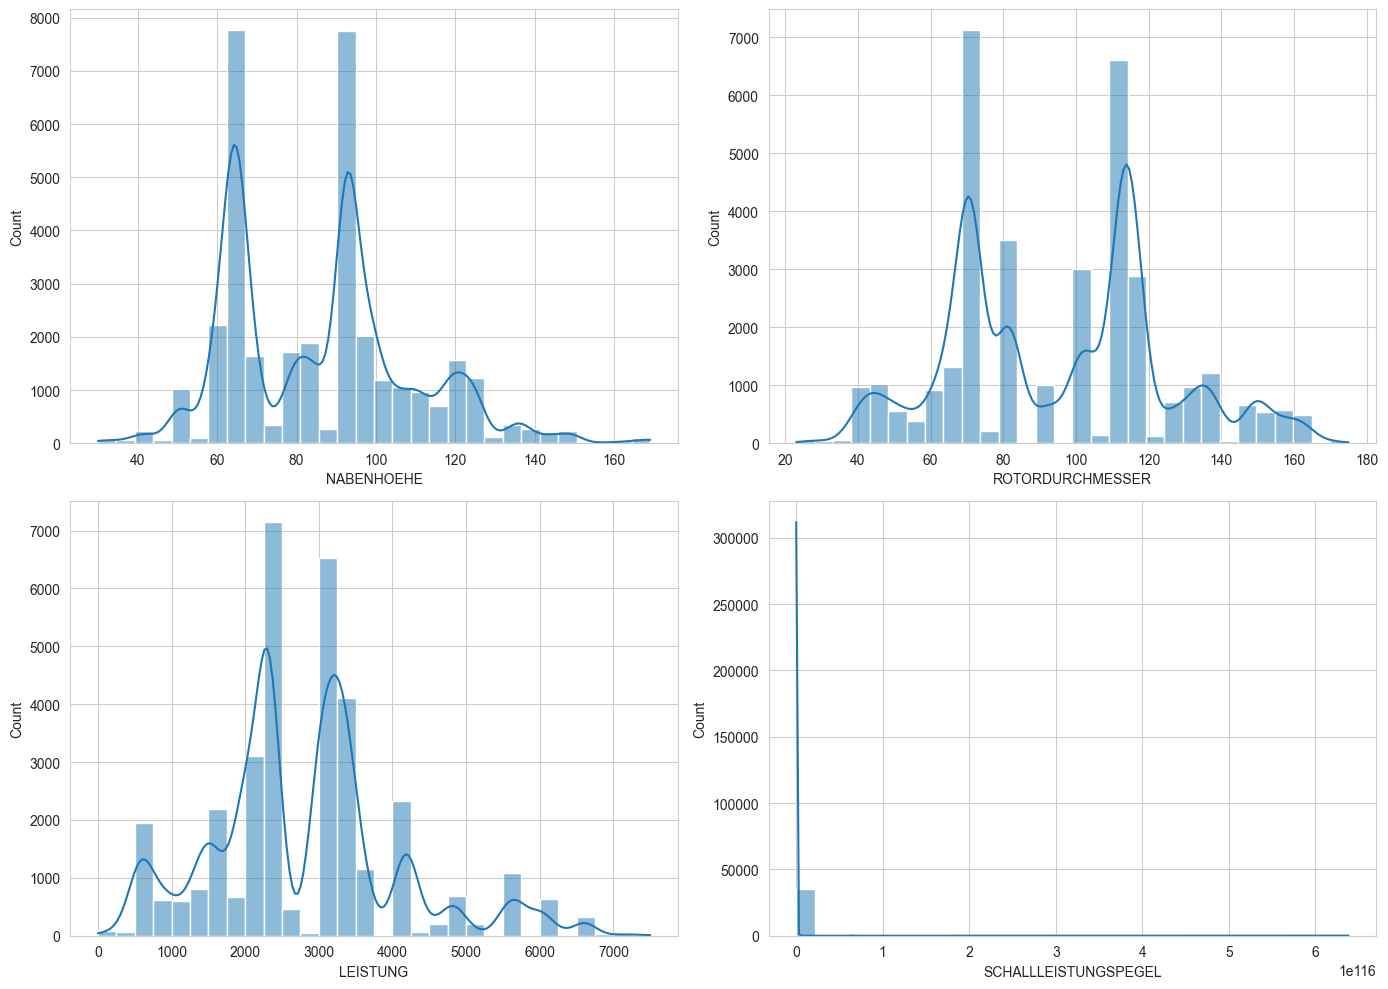

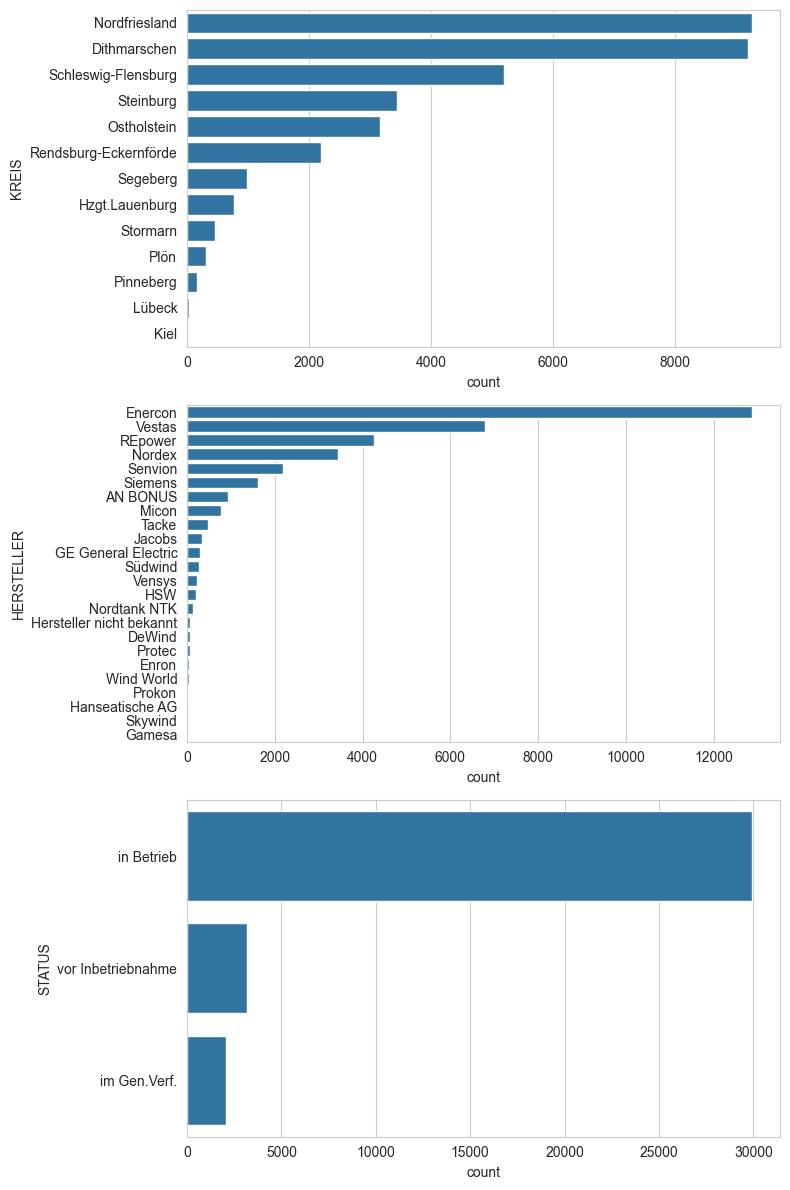

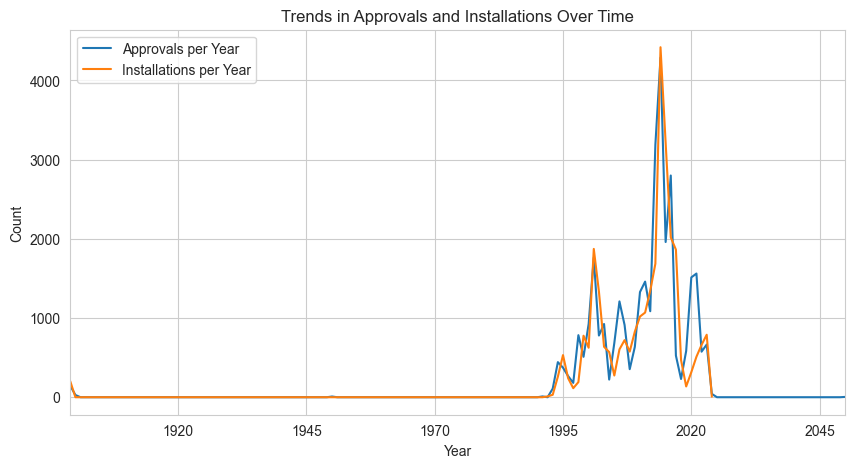

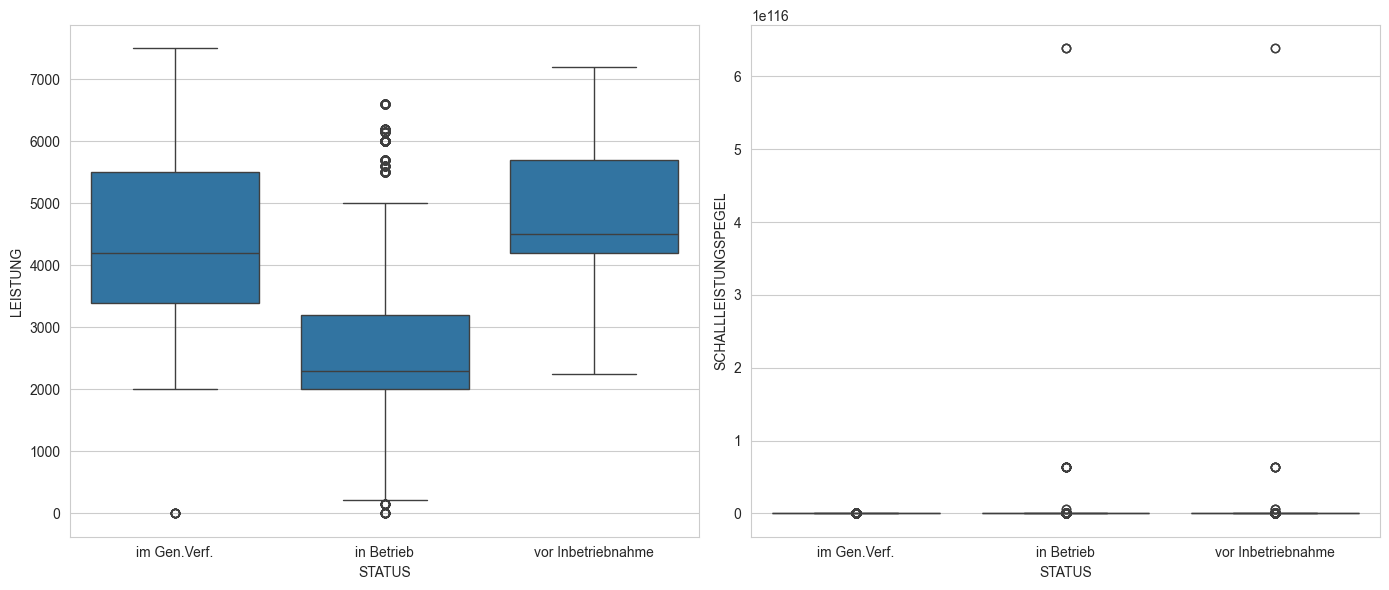

In [43]:


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Histograms for numerical data
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(data=result_df_clean, x='NABENHOEHE', bins=30, kde=True, ax=ax[0, 0])
sns.histplot(data=result_df_clean, x='ROTORDURCHMESSER', bins=30, kde=True, ax=ax[0, 1])
sns.histplot(data=result_df_clean, x='LEISTUNG', bins=30, kde=True, ax=ax[1, 0])
sns.histplot(data=result_df_clean, x='SCHALLLEISTUNGSPEGEL', bins=30, kde=True, ax=ax[1, 1])
plt.tight_layout()

# Count plots for categorical data
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
sns.countplot(y='KREIS', data=result_df_clean, ax=ax[0], order=result_df_clean['KREIS'].value_counts().index)
sns.countplot(y='HERSTELLER', data=result_df_clean, ax=ax[1], order=result_df_clean['HERSTELLER'].value_counts().index)
sns.countplot(y='STATUS', data=result_df_clean, ax=ax[2], order=result_df_clean['STATUS'].value_counts().index)
plt.tight_layout()

# Time series plot for approvals and installations
plt.figure(figsize=(10, 5))
result_df_clean.set_index('GENEHMIGT_AM').resample('Y').size().plot(label='Approvals per Year')
result_df_clean.set_index('INBETRIEBNAHME').resample('Y').size().plot(label='Installations per Year')
plt.title('Trends in Approvals and Installations Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()

# # Scatter plot for geographical data
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=result_df_clean, x='OSTWERT', y='NORDWERT', hue='HERSTELLER', style='STATUS', s=100, alpha=0.6)
# plt.title('Geographical Distribution of Entries')
# plt.xlabel('East Coordinate')
# plt.ylabel('North Coordinate')

# Box plots for outliers
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(x='STATUS', y='LEISTUNG', data=result_df_clean, ax=ax[0])
sns.boxplot(x='STATUS', y='SCHALLLEISTUNGSPEGEL', data=result_df_clean, ax=ax[1])
plt.tight_layout()

plt.show()


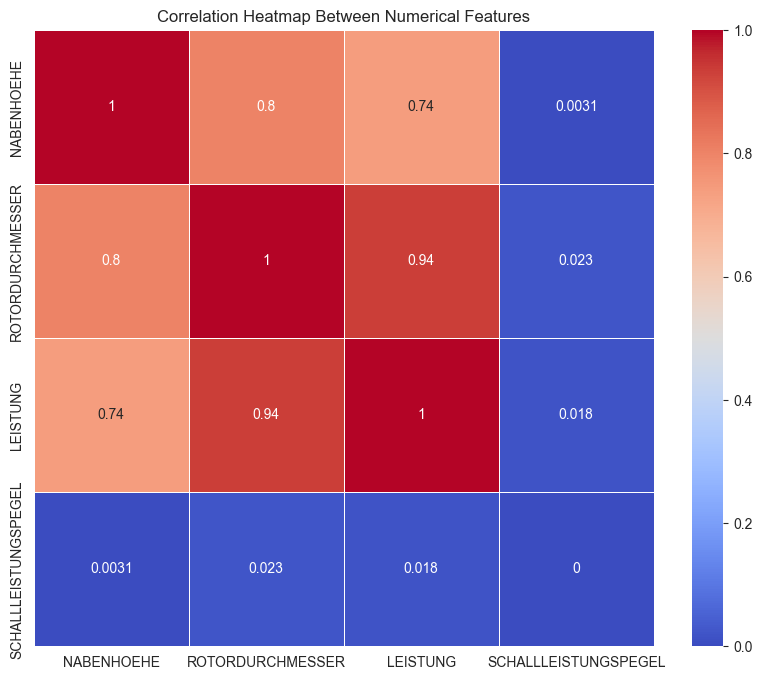

In [44]:


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation = result_df_clean[['NABENHOEHE', 'ROTORDURCHMESSER', 'LEISTUNG', 'SCHALLLEISTUNGSPEGEL']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap Between Numerical Features')
plt.show()


In [45]:
result_df_clean.dtypes

KREIS                         category
GEMEINDE                      category
TYP                           category
HERSTELLER                    category
NABENHOEHE                     float64
ROTORDURCHMESSER               float64
SCHALLLEISTUNGSPEGEL           float64
LEISTUNG                       float64
LEISTUNGSBEZUG                category
OSTWERT                        float64
NORDWERT                       float64
GENEHMIGT_AM            datetime64[ns]
INBETRIEBNAHME          datetime64[ns]
STATUS                        category
BST_NR                           int64
ANL_NR                           int64
DATENDATUM              datetime64[ns]
DATENQUELLE                   category
AKTENZEICHEN                  category
dtype: object

In [46]:
result_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35163 entries, 3 to 39007
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   KREIS                 35163 non-null  category      
 1   GEMEINDE              35163 non-null  category      
 2   TYP                   35163 non-null  category      
 3   HERSTELLER            35163 non-null  category      
 4   NABENHOEHE            35120 non-null  float64       
 5   ROTORDURCHMESSER      35119 non-null  float64       
 6   SCHALLLEISTUNGSPEGEL  35163 non-null  float64       
 7   LEISTUNG              35162 non-null  float64       
 8   LEISTUNGSBEZUG        35163 non-null  category      
 9   OSTWERT               35163 non-null  float64       
 10  NORDWERT              35163 non-null  float64       
 11  GENEHMIGT_AM          33085 non-null  datetime64[ns]
 12  INBETRIEBNAHME        29924 non-null  datetime64[ns]
 13  STATUS               

C:\Users\batik\AppData\Local\Temp\ipykernel_39296\2282078125.py:3: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = result_df_clean['LEISTUNG'].resample('A').mean()  # 'A' stands for annual frequency


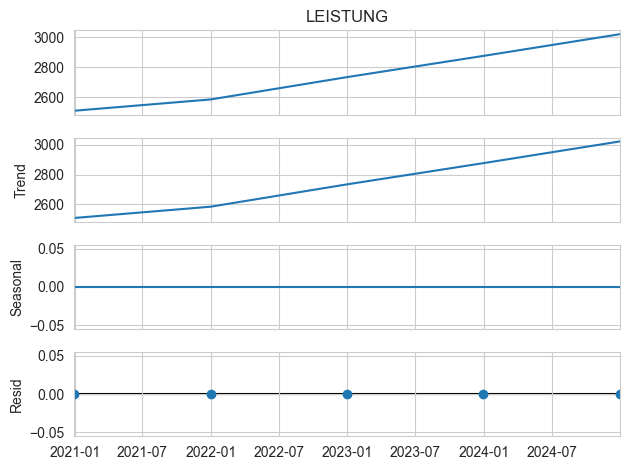

In [47]:

result_df_clean.set_index('DATENDATUM', inplace=True)

yearly_data = result_df_clean['LEISTUNG'].resample('A').mean()  # 'A' stands for annual frequency

yearly_data.dropna(inplace=True)

# Check if the index has a frequency set, set it if not
if yearly_data.index.freq is None:
    yearly_data.index.freq = 'A'  # Set the frequency to annual if it's not set

# Now you can decompose
decomposition = seasonal_decompose(yearly_data, model='additive')  # You can choose 'additive' or 'multiplicative'

# Plot the decomposed components of the time series
fig = decomposition.plot()
plt.show()


In [48]:
result_df_clean

,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENQUELLE,AKTENZEICHEN
DATENDATUM,,,,,,,,,,,,,,,,,,
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619817.0,5978875.0,2011-01-04,2012-09-25,in Betrieb,3000924205,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619815.0,5977994.0,2011-01-04,2012-09-25,in Betrieb,3000924205,2,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,tacke tw 600,Tacke,50.0,43.0,983.0,600.0,kW Nennleist. Rotor.,32620847.0,5977577.0,1996-04-16,1996-04-10,in Betrieb,3000924233,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516648.0,5999295.0,2013-07-10,2014-11-06,in Betrieb,51001900011,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516599.0,5998975.0,2013-07-10,2014-11-06,in Betrieb,51001900011,2,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593273.0,5969688.0,2002-08-14,2002-01-12,in Betrieb,62093445249,2,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593509.0,5969619.0,2002-08-14,2002-01-12,in Betrieb,62093445249,3,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,594038.0,5969465.0,2002-08-14,2002-01-12,in Betrieb,62093445249,4,"LfU SH, Abtl. 7",G30/028/2001-L108


In [49]:
result_df_clean.to_pickle('result_df_clean.pkl')


In [50]:
result_df_loaded = pd.read_pickle('result_df_clean.pkl')
result_df_loaded

,KREIS,GEMEINDE,TYP,HERSTELLER,NABENHOEHE,ROTORDURCHMESSER,SCHALLLEISTUNGSPEGEL,LEISTUNG,LEISTUNGSBEZUG,OSTWERT,NORDWERT,GENEHMIGT_AM,INBETRIEBNAHME,STATUS,BST_NR,ANL_NR,DATENQUELLE,AKTENZEICHEN
DATENDATUM,,,,,,,,,,,,,,,,,,
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619817.0,5978875.0,2011-01-04,2012-09-25,in Betrieb,3000924205,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,enercon e 82 e,Enercon,85.0,82.0,1045.0,2300.0,kW Nennleist. Rotor.,32619815.0,5977994.0,2011-01-04,2012-09-25,in Betrieb,3000924205,2,"LLUR SH, Abtl. 7",NaN
2020-10-19,Lübeck,Lübeck,tacke tw 600,Tacke,50.0,43.0,983.0,600.0,kW Nennleist. Rotor.,32620847.0,5977577.0,1996-04-16,1996-04-10,in Betrieb,3000924233,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516648.0,5999295.0,2013-07-10,2014-11-06,in Betrieb,51001900011,1,"LLUR SH, Abtl. 7",NaN
2020-10-19,Dithmarschen,Albersdorf,vestas v112,Vestas,119.0,112.0,1065.0,3300.0,kW Nennleist. Rotor.,32516599.0,5998975.0,2013-07-10,2014-11-06,in Betrieb,51001900011,2,"LLUR SH, Abtl. 7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593273.0,5969688.0,2002-08-14,2002-01-12,in Betrieb,62093445249,2,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,593509.0,5969619.0,2002-08-14,2002-01-12,in Betrieb,62093445249,3,"LfU SH, Abtl. 7",G30/028/2001-L108
2024-04-02,Stormarn,Feldhorst,jacobs md 70,Jacobs,65.0,70.0,103.0,1500.0,kW Nennleist. Rotor.,594038.0,5969465.0,2002-08-14,2002-01-12,in Betrieb,62093445249,4,"LfU SH, Abtl. 7",G30/028/2001-L108
